In [51]:
import os
import numpy as np
import pandas as pd
import time
from tqdm import tqdm 

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

import warnings
warnings.filterwarnings("ignore")

import sklearn.model_selection as skms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
root_path = '/kaggle/input'
dataset_path = os.path.join(root_path, "ki67-dataset")
training_path = os.path.join(dataset_path, "Dataset", "Training")
testing_path = os.path.join(dataset_path, "Dataset", "Testing")

In [3]:
#/kaggle/input/ki67-dataset/Dataset/Ki67_Image_results.xlsx

In [4]:
train_data = []
test_data = []

def process_folder(folder_path, data):
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder.replace(" 40x", "")
            label = int(label)

            for root, _, files in os.walk(subfolder_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):  
                        img_path = os.path.join(root, file)
                        data.append((img_path, label))  

process_folder(training_path, train_data)
process_folder(testing_path, test_data)

train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)

train_images_array = np.array(train_images)
train_labels_array = np.array(train_labels)
test_images_array = np.array(test_images)
test_labels_array = np.array(test_labels)

print("Train Images shape:", train_images_array.shape)
print("Train Labels shape:", train_labels_array.shape)
print("Test Images shape:", test_images_array.shape)
print("Test Labels shape:", test_labels_array.shape)


Train Images shape: (444,)
Train Labels shape: (444,)
Test Images shape: (55,)
Test Labels shape: (55,)


In [5]:
print(train_images_array[:10])
print(train_labels_array[:10])
print(test_images_array[:10])
print(test_labels_array[:10])

['/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4_.jpeg.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4__aug_0.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4__aug_3.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4__aug_1.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4__modified.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_2_modified.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_2_aug_2.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_2_aug_0.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4__aug_2.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_2.jpeg.jpeg']
[7530 7530 7530 7530 7530 7530 7530 7530 7530 7530]
['/kaggle/input/ki67-dataset/Dataset/Testing/7530/7530_3.jpeg.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Testing/7530/7530_5.jpeg.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Testing/6617/66171.jpeg.jpeg'
 '/kaggle/input/ki67-dataset/Datas

In [6]:
file_path = "/kaggle/input/ki67-dataset/Dataset/Ki67_Image_results.xlsx"
df = pd.read_excel(file_path, header=None, skiprows=3)

slide_numbers = []
pathologist_percentages = []

for index, row in df.iterrows():
    slide_number = row[1]  
    pathologist_percent = row[6]  

    if '-' in pathologist_percent:  
        range_values = pathologist_percent.split('-')
        upper_limit = int(range_values[1].rstrip('%'))  
        pathologist_percentages.append(upper_limit)
    else:
        pathologist_percentages.append(int(pathologist_percent.rstrip('%')))

    slide_numbers.append(int(slide_number))

In [7]:
slide_percentage_map = dict(zip(slide_numbers, pathologist_percentages))
print(slide_percentage_map)


{5424: 25, 6876: 5, 9124: 1, 9863: 55, 9871: 45, 10246: 50, 10439: 20, 12693: 3, 5883: 60, 6082: 30, 6481: 10, 6617: 15, 6754: 85, 6758: 40, 6930: 50, 7530: 70, 5428: 90, 5493: 20, 6238: 40, 6880: 35, 7158: 2, 7217: 40, 7271: 10}


In [8]:
def label_gen(labels_array):
    for i in range(len(labels_array)):
        label = labels_array[i]
        if label in slide_percentage_map:
            percentage_range = slide_percentage_map[label]
            if percentage_range <= 20:
                labels_array[i] = 0
            else:
                labels_array[i] = 1
    return labels_array


In [9]:
train_labels_array_ = label_gen(train_labels_array)
test_labels_array_ = label_gen(test_labels_array)

In [10]:
print(train_labels_array_[:20])
print(test_labels_array_[:20])

[   1    1    1    1    1    1    1    1    1    1    1    1    0    0
    0    0    0    0 7796 7796]
[   1    1    0 7796 7796    1    1    0    0    1    1    1    1 6312
 6312    0    0    0    0    1]


In [11]:
print("Train Labels shape:", (train_labels_array_.shape))
print("Test Labels shape:", test_labels_array_.shape)

Train Labels shape: (444,)
Test Labels shape: (55,)


In [12]:
def validate(labels_array, images_array):
    valid_indices = np.where((labels_array == 0) | (labels_array == 1))
    filtered_images = images_array[valid_indices]
    filtered_labels = labels_array[valid_indices]

    non_zero_indices = np.where((labels_array != 0) & (labels_array != 1))
    unlabelled_images = images_array[non_zero_indices]

    return filtered_images, filtered_labels, unlabelled_images

In [13]:
train_images, train_labels, test_images, test_labels = [],[],[],[]
unlabelled_images_train = []  # List to store unlabelled images from training dataset
unlabelled_images_test = []   # List to store unlabelled images from testing dataset

train_images, train_labels, unlabelled_images_train = validate(train_labels_array_, train_images_array)
test_images, test_labels, unlabelled_images_test = validate(test_labels_array_, test_images_array)

# Combine unlabelled images from both training and testing datasets
combined_unlabelled_images = np.concatenate((unlabelled_images_train, unlabelled_images_test), axis=0)

In [14]:
print("length of train label - ",len(train_labels))
print("length of train images - ",len(train_images))
print("length of test label - ",len(test_labels))
print("length of test images - ",len(test_images))

length of train label -  336
length of train images -  336
length of test label -  43
length of test images -  43


In [15]:
print("Filtered train images array:", train_images[:5])
print("Filtered train labels array:", train_labels[:5])
print("Filtered test images array:", test_images[:5])
print("Filtered test labels array:", test_labels[:5])

Filtered train images array: ['/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4_.jpeg.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4__aug_0.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4__aug_3.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4__aug_1.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Training/7530/7530_4__modified.jpeg']
Filtered train labels array: [1 1 1 1 1]
Filtered test images array: ['/kaggle/input/ki67-dataset/Dataset/Testing/7530/7530_3.jpeg.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Testing/7530/7530_5.jpeg.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Testing/6617/66171.jpeg.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Testing/7217/7217_2.jpeg.jpeg'
 '/kaggle/input/ki67-dataset/Dataset/Testing/7217/7217_5.jpeg.jpeg']
Filtered test labels array: [1 1 0 1 1]


In [16]:
train_images_array = np.array(train_images)
train_labels_array = np.array(train_labels)
test_images_array = np.array(test_images)
test_labels_array = np.array(test_labels)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images 
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(image_path).convert("RGB")  
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [18]:
transform = transforms.Compose([
    transforms.Resize((325, 325)),
    transforms.ToTensor(), 
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [19]:
# Split the indices into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(train_images_array))), test_size=0.2, random_state=42)

# Create CustomDataset and DataLoader for training dataset
train_dataset = CustomDataset([train_images_array[i] for i in train_indices], [train_labels_array[i] for i in train_indices], transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create CustomDataset and DataLoader for validation dataset
val_dataset = CustomDataset([train_images_array[i] for i in val_indices], [train_labels_array[i] for i in val_indices], transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create CustomDataset and DataLoader for the test dataset
test_dataset = CustomDataset(test_images_array, test_labels_array, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
num_epochs = 10
num_classes = len(set(train_labels))
learning_rate = 0.001
batch_size = 32

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [64]:
model_name = 'resnet50'
print(f"Training {model_name} on {device}...")

model_resnet = models.resnet50(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=initial_learning_rate)

# Initialize a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

resnet_training_time = 0
best_val_loss = float('inf')
best_epoch = 0

resnet_loss = []  # Modify this line to create an empty list for validation loss

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}] for {model_name}")
    epoch_loss = 0.0
    total_batches = len(train_dataloader)
    progress_bar = tqdm(train_dataloader, unit="batch", total=total_batches)

    start_epoch_time = time.time()  

    for batch_images, batch_labels in progress_bar:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    end_epoch_time = time.time()  
    epoch_time = end_epoch_time - start_epoch_time
    resnet_training_time += epoch_time  

    avg_epoch_loss = epoch_loss / total_batches
    print(f'Epoch [{epoch+1}/{num_epochs}] for {model_name}, Avg. Loss: {avg_epoch_loss:.4f}')

    # Validate the model on the validation dataset
    model_resnet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_resnet(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
    model_resnet.train()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}] for {model_name}, Avg. Validation Loss: {avg_val_loss:.4f}')
    
    # Append the validation loss to the resnet_loss list
    resnet_loss.append(f"{avg_val_loss:.2f}")

    # Update the learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Check if the validation loss is the best so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch

    if epoch > best_epoch + 5:
        print("Early stopping as the validation loss has not improved in the last 5 epochs.")
        break

print(f"Finished training {model_name}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Total training time: {resnet_training_time:.2f} seconds")

Training resnet50 on cuda...

Epoch [1/10] for resnet50


100%|██████████| 9/9 [00:08<00:00,  1.12batch/s, Loss=0.734]


Epoch [1/10] for resnet50, Avg. Loss: 0.6666
Epoch [1/10] for resnet50, Avg. Validation Loss: 11.7997

Epoch [2/10] for resnet50


100%|██████████| 9/9 [00:07<00:00,  1.13batch/s, Loss=0.0727]


Epoch [2/10] for resnet50, Avg. Loss: 0.2436
Epoch [2/10] for resnet50, Avg. Validation Loss: 0.2068

Epoch [3/10] for resnet50


100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, Loss=0.418] 


Epoch [3/10] for resnet50, Avg. Loss: 0.1619
Epoch [3/10] for resnet50, Avg. Validation Loss: 0.1932

Epoch [4/10] for resnet50


100%|██████████| 9/9 [00:08<00:00,  1.07batch/s, Loss=0.139] 


Epoch [4/10] for resnet50, Avg. Loss: 0.1469
Epoch [4/10] for resnet50, Avg. Validation Loss: 0.2880

Epoch [5/10] for resnet50


100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, Loss=0.203] 


Epoch [5/10] for resnet50, Avg. Loss: 0.0666
Epoch [5/10] for resnet50, Avg. Validation Loss: 0.0460

Epoch [6/10] for resnet50


100%|██████████| 9/9 [00:08<00:00,  1.12batch/s, Loss=0.0556] 


Epoch [6/10] for resnet50, Avg. Loss: 0.0555
Epoch [6/10] for resnet50, Avg. Validation Loss: 0.1056

Epoch [7/10] for resnet50


100%|██████████| 9/9 [00:08<00:00,  1.04batch/s, Loss=0.0492] 


Epoch [7/10] for resnet50, Avg. Loss: 0.0607
Epoch [7/10] for resnet50, Avg. Validation Loss: 0.2654

Epoch [8/10] for resnet50


100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, Loss=0.407]  


Epoch [8/10] for resnet50, Avg. Loss: 0.0721
Epoch [8/10] for resnet50, Avg. Validation Loss: 0.0581
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.

Epoch [9/10] for resnet50


100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, Loss=0.136]  


Epoch [9/10] for resnet50, Avg. Loss: 0.0342
Epoch [9/10] for resnet50, Avg. Validation Loss: 0.0433

Epoch [10/10] for resnet50


100%|██████████| 9/9 [00:08<00:00,  1.05batch/s, Loss=0.0028] 


Epoch [10/10] for resnet50, Avg. Loss: 0.0135
Epoch [10/10] for resnet50, Avg. Validation Loss: 0.0660
Finished training resnet50
Best Validation Loss: 0.0433
Total training time: 82.02 seconds


In [65]:
model_name = 'inception_v3'
print(f"Training {model_name} on {device}...")

learning_rate = 0.001
initial_learning_rate = learning_rate
patience = 5  # Patience for early stopping
lr_step_size = 10  # Reduce learning rate every 10 epochs
lr_gamma = 0.1

model_inception = models.inception_v3(pretrained=True)
num_ftrs = model_inception.fc.in_features
model_inception.fc = nn.Linear(num_ftrs, num_classes)
model_inception.AuxLogits.fc = nn.Linear(768, num_classes)
model_inception.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_inception.parameters(), lr=initial_learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)

# Initialize other variables
best_val_loss = float('inf')
inception_training_time = 0
best_epoch = 0

inception_loss = []  # Modify this line to create an empty list for validation loss

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}] for {model_name}")

    epoch_loss = 0.0
    total_batches = len(train_dataloader)

    progress_bar = tqdm(train_dataloader, unit="batch", total=total_batches)

    model_inception.train()  # Set the model to training mode

    start_epoch_time = time.time()  # Start measuring epoch training time

    for batch_images, batch_labels in progress_bar:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs, aux_outputs = model_inception(batch_images)
        loss1 = criterion(outputs, batch_labels)
        loss2 = criterion(aux_outputs, batch_labels) * 0.4
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    end_epoch_time = time.time()  # End measuring epoch training time
    epoch_time = end_epoch_time - start_epoch_time
    inception_training_time += epoch_time  # Accumulate epoch training time

    avg_epoch_loss = epoch_loss / total_batches
    print(f'Epoch [{epoch+1}/{num_epochs}] for {model_name}, Avg. Loss: {avg_epoch_loss:.4f}')

    # Validate the model on the validation dataset
    model_inception.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_inception(val_images)  # Main output
            val_loss += criterion(val_outputs, val_labels).item()
    model_inception.train()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}] for {model_name}, Avg. Validation Loss: {avg_val_loss:.4f}')
    
    # Append the validation loss to the inception_loss list
    inception_loss.append(f"{avg_val_loss:.2f}")

    # Update learning rate scheduler with the validation loss
    lr_scheduler.step(avg_val_loss)

    # Get the current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Check for early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch

    if epoch > best_epoch + 5:
        print("Early stopping as the validation loss has not improved in the last 5 epochs.")
        break

print(f"Finished training {model_name}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Total training time: {inception_training_time:.2f} seconds")

Training inception_v3 on cuda...

Epoch [1/10] for inception_v3


100%|██████████| 9/9 [00:07<00:00,  1.18batch/s, Loss=0.0116]


Epoch [1/10] for inception_v3, Avg. Loss: 0.4482
Epoch [1/10] for inception_v3, Avg. Validation Loss: 3.9297

Epoch [2/10] for inception_v3


100%|██████████| 9/9 [00:07<00:00,  1.18batch/s, Loss=1.16]  


Epoch [2/10] for inception_v3, Avg. Loss: 0.2328
Epoch [2/10] for inception_v3, Avg. Validation Loss: 2.5849

Epoch [3/10] for inception_v3


100%|██████████| 9/9 [00:07<00:00,  1.16batch/s, Loss=0.0415]


Epoch [3/10] for inception_v3, Avg. Loss: 0.2000
Epoch [3/10] for inception_v3, Avg. Validation Loss: 14.4483

Epoch [4/10] for inception_v3


100%|██████████| 9/9 [00:08<00:00,  1.09batch/s, Loss=0.394] 


Epoch [4/10] for inception_v3, Avg. Loss: 0.1919
Epoch [4/10] for inception_v3, Avg. Validation Loss: 4.8784

Epoch [5/10] for inception_v3


100%|██████████| 9/9 [00:07<00:00,  1.14batch/s, Loss=0.0538]


Epoch [5/10] for inception_v3, Avg. Loss: 0.1834
Epoch [5/10] for inception_v3, Avg. Validation Loss: 3.3553

Epoch [6/10] for inception_v3


100%|██████████| 9/9 [00:07<00:00,  1.16batch/s, Loss=0.024] 


Epoch [6/10] for inception_v3, Avg. Loss: 0.0650
Epoch [6/10] for inception_v3, Avg. Validation Loss: 0.0915

Epoch [7/10] for inception_v3


100%|██████████| 9/9 [00:08<00:00,  1.09batch/s, Loss=0.00284]


Epoch [7/10] for inception_v3, Avg. Loss: 0.0204
Epoch [7/10] for inception_v3, Avg. Validation Loss: 0.0868

Epoch [8/10] for inception_v3


100%|██████████| 9/9 [00:07<00:00,  1.16batch/s, Loss=0.118]  


Epoch [8/10] for inception_v3, Avg. Loss: 0.0218
Epoch [8/10] for inception_v3, Avg. Validation Loss: 0.0505

Epoch [9/10] for inception_v3


100%|██████████| 9/9 [00:07<00:00,  1.16batch/s, Loss=0.0433] 


Epoch [9/10] for inception_v3, Avg. Loss: 0.0776
Epoch [9/10] for inception_v3, Avg. Validation Loss: 0.1009

Epoch [10/10] for inception_v3


100%|██████████| 9/9 [00:07<00:00,  1.17batch/s, Loss=0.000757]


Epoch [10/10] for inception_v3, Avg. Loss: 0.0456
Epoch [10/10] for inception_v3, Avg. Validation Loss: 0.0857
Finished training inception_v3
Best Validation Loss: 0.0505
Total training time: 78.40 seconds


In [66]:
model_name = 'mobilenet_v2'
print(f"Training {model_name} on {device}...")

model_mobilenet = models.mobilenet_v2(pretrained=True)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, num_classes)
model_mobilenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenet.parameters(), lr=initial_learning_rate)

# Initialize a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

mobilenet_training_time = 0
best_val_loss = float('inf')
best_epoch = 0

mobilenet_loss = []  # Modify this line to create an empty list for validation loss

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}] for {model_name}")

    epoch_loss = 0.0
    total_batches = len(train_dataloader)

    progress_bar = tqdm(train_dataloader, unit="batch", total=total_batches)

    start_epoch_time = time.time()  # Start measuring epoch training time

    for batch_images, batch_labels in progress_bar:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model_mobilenet(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    end_epoch_time = time.time()  # End measuring epoch training time
    epoch_time = end_epoch_time - start_epoch_time
    mobilenet_training_time += epoch_time  # Accumulate epoch training time

    avg_epoch_loss = epoch_loss / total_batches
    print(f'Epoch [{epoch+1}/{num_epochs}] for {model_name}, Avg. Loss: {avg_epoch_loss:.4f}')

    # Validate the model on the validation dataset
    model_mobilenet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_mobilenet(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
    model_mobilenet.train()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}] for {model_name}, Avg. Validation Loss: {avg_val_loss:.4f}')
    
    # Append the validation loss to the loss_mobilenet list
    mobilenet_loss.append(f"{avg_val_loss:.2f}")

    # Update the learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Check if the validation loss is the best so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch

    if epoch > best_epoch + 5:
        print("Early stopping as the validation loss has not improved in the last 5 epochs.")
        break

print(f"Finished training {model_name}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Total training time: {mobilenet_training_time:.2f} seconds")

Training mobilenet_v2 on cuda...

Epoch [1/10] for mobilenet_v2


100%|██████████| 9/9 [00:06<00:00,  1.34batch/s, Loss=0.144]


Epoch [1/10] for mobilenet_v2, Avg. Loss: 0.3369
Epoch [1/10] for mobilenet_v2, Avg. Validation Loss: 2.5511

Epoch [2/10] for mobilenet_v2


100%|██████████| 9/9 [00:06<00:00,  1.41batch/s, Loss=0.0631]


Epoch [2/10] for mobilenet_v2, Avg. Loss: 0.1364
Epoch [2/10] for mobilenet_v2, Avg. Validation Loss: 0.3189

Epoch [3/10] for mobilenet_v2


100%|██████████| 9/9 [00:06<00:00,  1.39batch/s, Loss=0.00199]


Epoch [3/10] for mobilenet_v2, Avg. Loss: 0.0507
Epoch [3/10] for mobilenet_v2, Avg. Validation Loss: 1.5534

Epoch [4/10] for mobilenet_v2


100%|██████████| 9/9 [00:06<00:00,  1.39batch/s, Loss=0.00137] 


Epoch [4/10] for mobilenet_v2, Avg. Loss: 0.0114
Epoch [4/10] for mobilenet_v2, Avg. Validation Loss: 0.0802

Epoch [5/10] for mobilenet_v2


100%|██████████| 9/9 [00:07<00:00,  1.29batch/s, Loss=0.000396]


Epoch [5/10] for mobilenet_v2, Avg. Loss: 0.0220
Epoch [5/10] for mobilenet_v2, Avg. Validation Loss: 0.0625

Epoch [6/10] for mobilenet_v2


100%|██████████| 9/9 [00:06<00:00,  1.40batch/s, Loss=0.00908] 


Epoch [6/10] for mobilenet_v2, Avg. Loss: 0.0201
Epoch [6/10] for mobilenet_v2, Avg. Validation Loss: 0.1405

Epoch [7/10] for mobilenet_v2


100%|██████████| 9/9 [00:06<00:00,  1.39batch/s, Loss=0.00174] 


Epoch [7/10] for mobilenet_v2, Avg. Loss: 0.0052
Epoch [7/10] for mobilenet_v2, Avg. Validation Loss: 0.0726

Epoch [8/10] for mobilenet_v2


100%|██████████| 9/9 [00:06<00:00,  1.33batch/s, Loss=0.141]   


Epoch [8/10] for mobilenet_v2, Avg. Loss: 0.0248
Epoch [8/10] for mobilenet_v2, Avg. Validation Loss: 0.0689
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.

Epoch [9/10] for mobilenet_v2


100%|██████████| 9/9 [00:07<00:00,  1.27batch/s, Loss=0.351]  


Epoch [9/10] for mobilenet_v2, Avg. Loss: 0.0427
Epoch [9/10] for mobilenet_v2, Avg. Validation Loss: 0.0294

Epoch [10/10] for mobilenet_v2


100%|██████████| 9/9 [00:06<00:00,  1.40batch/s, Loss=0.000535]


Epoch [10/10] for mobilenet_v2, Avg. Loss: 0.0029
Epoch [10/10] for mobilenet_v2, Avg. Validation Loss: 0.0434
Finished training mobilenet_v2
Best Validation Loss: 0.0294
Total training time: 66.25 seconds


In [69]:
model_name = 'densenet121'
print(f"Training {model_name} on {device}...")

model_densenet = models.densenet121(pretrained=True)
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, num_classes)
model_densenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_densenet.parameters(), lr=initial_learning_rate)

# Initialize a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

densenet_training_time = 0
best_val_loss = float('inf')
best_epoch = 0

densenet_loss = []  # Create an empty list for validation loss

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}] for {model_name}")

    epoch_loss = 0.0
    total_batches = len(train_dataloader)

    progress_bar = tqdm(train_dataloader, unit="batch", total=total_batches)

    start_epoch_time = time.time()  # Start measuring epoch training time

    for batch_images, batch_labels in progress_bar:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model_densenet(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    end_epoch_time = time.time()  # End measuring epoch training time
    epoch_time = end_epoch_time - start_epoch_time
    densenet_training_time += epoch_time  # Accumulate epoch training time

    avg_epoch_loss = epoch_loss / total_batches
    print(f'Epoch [{epoch+1}/{num_epochs}] for {model_name}, Avg. Loss: {avg_epoch_loss:.4f}')

    # Validate the model on the validation dataset
    model_densenet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_densenet(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
    model_densenet.train()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}] for {model_name}, Avg. Validation Loss: {avg_val_loss:.4f}')
    
    # Append the validation loss to the loss_densenet list
    densenet_loss.append(f"{avg_val_loss:.2f}")

    # Update the learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Check if the validation loss is the best so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch

    if epoch > best_epoch + 5:
        print("Early stopping as the validation loss has not improved in the last 5 epochs.")
        break

print(f"Finished training {model_name}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Total training time: {densenet_training_time:.2f} seconds")

Training densenet121 on cuda...

Epoch [1/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.04batch/s, Loss=0.127] 


Epoch [1/10] for densenet121, Avg. Loss: 0.3783
Epoch [1/10] for densenet121, Avg. Validation Loss: 1.1812

Epoch [2/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.02batch/s, Loss=0.435] 


Epoch [2/10] for densenet121, Avg. Loss: 0.1325
Epoch [2/10] for densenet121, Avg. Validation Loss: 0.3100

Epoch [3/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.12batch/s, Loss=0.0545]


Epoch [3/10] for densenet121, Avg. Loss: 0.0588
Epoch [3/10] for densenet121, Avg. Validation Loss: 0.2698

Epoch [4/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.03batch/s, Loss=0.0173]


Epoch [4/10] for densenet121, Avg. Loss: 0.0262
Epoch [4/10] for densenet121, Avg. Validation Loss: 2.2192

Epoch [5/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.10batch/s, Loss=0.00632]


Epoch [5/10] for densenet121, Avg. Loss: 0.0173
Epoch [5/10] for densenet121, Avg. Validation Loss: 0.0762

Epoch [6/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.04batch/s, Loss=0.0343] 


Epoch [6/10] for densenet121, Avg. Loss: 0.0248
Epoch [6/10] for densenet121, Avg. Validation Loss: 0.1206

Epoch [7/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.09batch/s, Loss=0.0397] 


Epoch [7/10] for densenet121, Avg. Loss: 0.0124
Epoch [7/10] for densenet121, Avg. Validation Loss: 0.0137

Epoch [8/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.10batch/s, Loss=0.00196]


Epoch [8/10] for densenet121, Avg. Loss: 0.0149
Epoch [8/10] for densenet121, Avg. Validation Loss: 0.0339

Epoch [9/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.09batch/s, Loss=0.00455]


Epoch [9/10] for densenet121, Avg. Loss: 0.0162
Epoch [9/10] for densenet121, Avg. Validation Loss: 0.0568

Epoch [10/10] for densenet121


100%|██████████| 9/9 [00:08<00:00,  1.06batch/s, Loss=0.00722]


Epoch [10/10] for densenet121, Avg. Loss: 0.0045
Epoch [10/10] for densenet121, Avg. Validation Loss: 0.0827
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.
Finished training densenet121
Best Validation Loss: 0.0137
Total training time: 84.28 seconds


In [70]:
total_correct_resnet = 0
total_correct_inception = 0
total_correct_mobilenet = 0
total_correct_densenet = 0

true_labels = []
predicted_labels_resnet = []
predicted_labels_inception = []
predicted_labels_mobilenet = []
predicted_labels_densenet = []

with torch.no_grad():
    for batch_images, batch_labels in test_dataloader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        
        predictions_resnet = model_resnet(batch_images)
        predictions_inception = model_inception(batch_images).logits  
        predictions_mobilenet = model_mobilenet(batch_images)
        predictions_densenet = model_densenet(batch_images)
        
        total_correct_resnet += (torch.argmax(predictions_resnet, dim=1) == batch_labels).sum().item()
        total_correct_inception += (torch.argmax(predictions_inception, dim=1) == batch_labels).sum().item()
        total_correct_mobilenet += (torch.argmax(predictions_mobilenet, dim=1) == batch_labels).sum().item()
        total_correct_densenet += (torch.argmax(predictions_densenet, dim=1) == batch_labels).sum().item()

        true_labels.extend(batch_labels.cpu().numpy())
        predicted_labels_resnet.extend(torch.argmax(predictions_resnet, dim=1).cpu().numpy())
        predicted_labels_inception.extend(torch.argmax(predictions_inception, dim=1).cpu().numpy())
        predicted_labels_mobilenet.extend(torch.argmax(predictions_mobilenet, dim=1).cpu().numpy())
        predicted_labels_densenet.extend(torch.argmax(predictions_densenet, dim=1).cpu().numpy())

accuracy_resnet = accuracy_score(true_labels, predicted_labels_resnet)
accuracy_inception = accuracy_score(true_labels, predicted_labels_inception)
accuracy_mobilenet = accuracy_score(true_labels, predicted_labels_mobilenet)
accuracy_densenet = accuracy_score(true_labels, predicted_labels_densenet)

precision_resnet = precision_score(true_labels, predicted_labels_resnet, average='weighted')
recall_resnet = recall_score(true_labels, predicted_labels_resnet, average='weighted')
f1_resnet = f1_score(true_labels, predicted_labels_resnet, average='weighted')

precision_inception = precision_score(true_labels, predicted_labels_inception, average='weighted')
recall_inception = recall_score(true_labels, predicted_labels_inception, average='weighted')
f1_inception = f1_score(true_labels, predicted_labels_inception, average='weighted')

precision_mobilenet = precision_score(true_labels, predicted_labels_mobilenet, average='weighted')
recall_mobilenet = recall_score(true_labels, predicted_labels_mobilenet, average='weighted')
f1_mobilenet = f1_score(true_labels, predicted_labels_mobilenet, average='weighted')

precision_densenet = precision_score(true_labels, predicted_labels_densenet, average='weighted')
recall_densenet = recall_score(true_labels, predicted_labels_densenet, average='weighted')
f1_densenet = f1_score(true_labels, predicted_labels_densenet, average='weighted')

print(f"Accuracy for 'resnet50': {accuracy_resnet:.2%}")
print(f"Precision for 'resnet50': {precision_resnet:.2%}")
print(f"Recall for 'resnet50': {recall_resnet:.2%}")
print(f"F1-score for 'resnet50': {f1_resnet:.2%}")

print(f"\nAccuracy for 'inception_v3': {accuracy_inception:.2%}")
print(f"Precision for 'inception_v3': {precision_inception:.2%}")
print(f"Recall for 'inception_v3': {recall_inception:.2%}")
print(f"F1-score for 'inception_v3': {f1_inception:.2%}")

print(f"\nAccuracy for 'mobilenet_v2': {accuracy_mobilenet:.2%}")
print(f"Precision for 'mobilenet_v2': {precision_mobilenet:.2%}")
print(f"Recall for 'mobilenet_v2': {recall_mobilenet:.2%}")
print(f"F1-score for 'mobilenet_v2': {f1_mobilenet:.2%}")

print(f"\nAccuracy for 'densenet121': {accuracy_densenet:.2%}")
print(f"Precision for 'densenet121': {precision_densenet:.2%}")
print(f"Recall for 'densenet121': {recall_densenet:.2%}")
print(f"F1-score for 'densenet121': {f1_densenet:.2%}")


Accuracy for 'resnet50': 93.02%
Precision for 'resnet50': 93.05%
Recall for 'resnet50': 93.02%
F1-score for 'resnet50': 92.98%

Accuracy for 'inception_v3': 97.67%
Precision for 'inception_v3': 97.80%
Recall for 'inception_v3': 97.67%
F1-score for 'inception_v3': 97.68%

Accuracy for 'mobilenet_v2': 95.35%
Precision for 'mobilenet_v2': 95.35%
Recall for 'mobilenet_v2': 95.35%
F1-score for 'mobilenet_v2': 95.35%

Accuracy for 'densenet121': 93.02%
Precision for 'densenet121': 93.74%
Recall for 'densenet121': 93.02%
F1-score for 'densenet121': 92.88%


In [71]:
print(inception_loss)
print(resnet_loss)
print(mobilenet_loss)
print(densenet_loss)

['3.93', '2.58', '14.45', '4.88', '3.36', '0.09', '0.09', '0.05', '0.10', '0.09']
['11.80', '0.21', '0.19', '0.29', '0.05', '0.11', '0.27', '0.06', '0.04', '0.07']
['2.55', '0.32', '1.55', '0.08', '0.06', '0.14', '0.07', '0.07', '0.03', '0.04']
['1.18', '0.31', '0.27', '2.22', '0.08', '0.12', '0.01', '0.03', '0.06', '0.08']


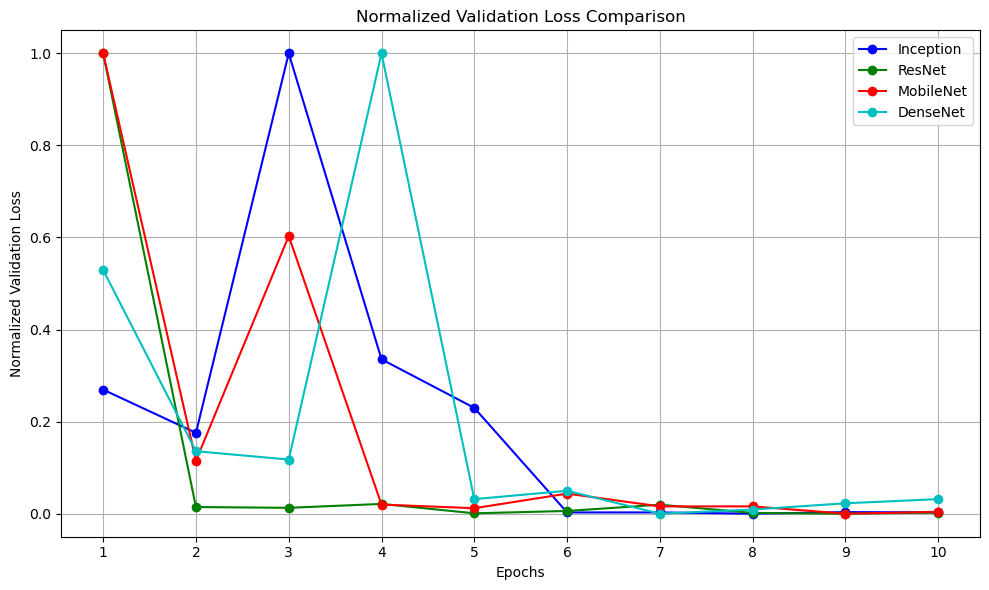

In [73]:
import matplotlib.pyplot as plt

# Define the validation losses for each model
inception_loss = [3.93, 2.58, 14.45, 4.88, 3.36, 0.09, 0.09, 0.05, 0.10, 0.09]
resnet_loss = [11.80, 0.21, 0.19, 0.29, 0.05, 0.11, 0.27, 0.06, 0.04, 0.07]
mobilenet_loss = [2.55, 0.32, 1.55, 0.08, 0.06, 0.14, 0.07, 0.07, 0.03, 0.04]
densenet_loss = [1.18, 0.31, 0.27, 2.22, 0.08, 0.12, 0.01, 0.03, 0.06, 0.08]

# Normalize the loss values between 0 and 1
def normalize(loss_values):
    min_val = min(loss_values)
    max_val = max(loss_values)
    return [(val - min_val) / (max_val - min_val) for val in loss_values]

inception_loss_normalized = normalize(inception_loss)
resnet_loss_normalized = normalize(resnet_loss)
mobilenet_loss_normalized = normalize(mobilenet_loss)
densenet_loss_normalized = normalize(densenet_loss)

# Create a list of epochs (x-axis values)
epochs = list(range(1, 11))

# Plot the normalized validation losses for each model
plt.figure(figsize=(10, 6))
plt.plot(epochs, inception_loss_normalized, marker='o', label='Inception', linestyle='-', color='b')
plt.plot(epochs, resnet_loss_normalized, marker='o', label='ResNet', linestyle='-', color='g')
plt.plot(epochs, mobilenet_loss_normalized, marker='o', label='MobileNet', linestyle='-', color='r')
plt.plot(epochs, densenet_loss_normalized, marker='o', label='DenseNet', linestyle='-', color='c')

# Set plot labels and title
plt.xlabel('Epochs')
plt.ylabel('Normalized Validation Loss')
plt.title('Normalized Validation Loss Comparison')
plt.xticks(epochs)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


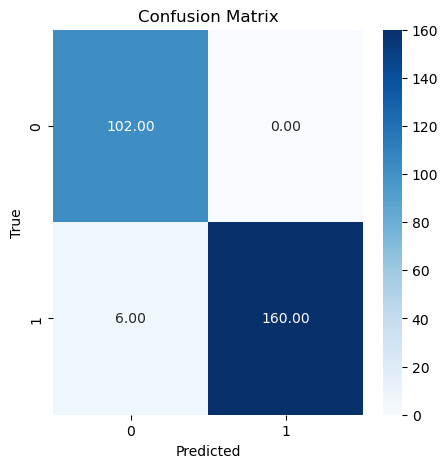

In [74]:
class_names = ['0','1']

model_resnet.eval()
confusion_mtx = torch.zeros(num_classes, num_classes)

for batch_images, batch_labels in train_dataloader:
    batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
    with torch.no_grad():
        outputs = model_resnet(batch_images)
        predicted_labels = torch.argmax(outputs, dim=1)
        confusion_mtx += confusion_matrix(batch_labels.cpu(), predicted_labels.cpu(), labels=range(num_classes))

plt.figure(figsize=(5,5))
sns.heatmap(confusion_mtx, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

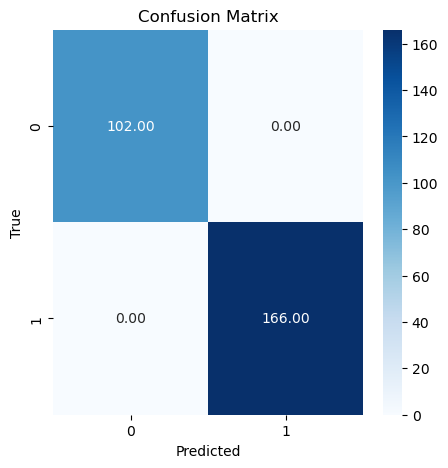

In [75]:
model_inception.eval()
confusion_mtx = torch.zeros(num_classes, num_classes)

for batch_images, batch_labels in train_dataloader:
    batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
    with torch.no_grad():
        outputs = model_inception(batch_images)
        predicted_labels = torch.argmax(outputs, dim=1)
        confusion_mtx += confusion_matrix(batch_labels.cpu(), predicted_labels.cpu(), labels=range(num_classes))

plt.figure(figsize=(5,5))
sns.heatmap(confusion_mtx, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

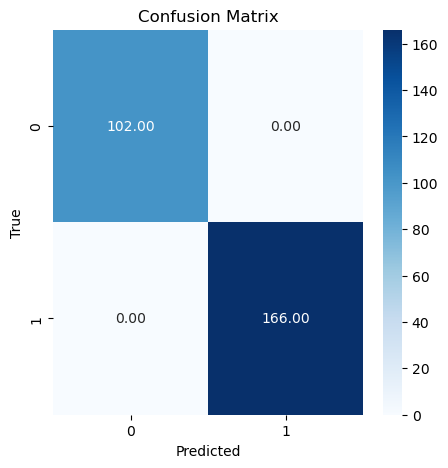

In [76]:
model_mobilenet.eval()
confusion_mtx = torch.zeros(num_classes, num_classes)

for batch_images, batch_labels in train_dataloader:
    batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
    with torch.no_grad():
        outputs = model_mobilenet(batch_images)
        predicted_labels = torch.argmax(outputs, dim=1)
        confusion_mtx += confusion_matrix(batch_labels.cpu(), predicted_labels.cpu(), labels=range(num_classes))

plt.figure(figsize=(5,5))
sns.heatmap(confusion_mtx, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

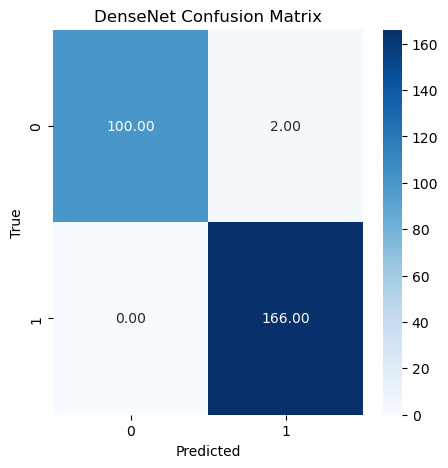

In [79]:
model_densenet.eval()
confusion_mtx_densenet = torch.zeros(num_classes, num_classes)

for batch_images, batch_labels in train_dataloader:
    batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
    with torch.no_grad():
        outputs_densenet = model_densenet(batch_images)
        predicted_labels_densenet = torch.argmax(outputs_densenet, dim=1)
        confusion_mtx_densenet += confusion_matrix(batch_labels.cpu(), predicted_labels_densenet.cpu(), labels=range(num_classes))

plt.figure(figsize=(5, 5))

sns.heatmap(confusion_mtx_densenet, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DenseNet Confusion Matrix")
plt.show()

In [87]:


# Assuming you have already calculated the necessary values and stored them in variables
model_names = ['ResNet-50', 'Inception', 'MobileNetV2', 'DenseNet121']
epochs = [10, 10, 10, 10]
avg_losses = [round(sum(resnet_loss) / 10, 2), round(sum(inception_loss) / 10, 2), round(sum(mobilenet_loss) / 10, 2), round(sum(densenet_loss) / 10, 2)]
training_times = [round(resnet_training_time, 2), round(inception_training_time, 2), round(mobilenet_training_time, 2), round(densenet_training_time, 2)]
accuracies = [round(accuracy_resnet, 2), round(accuracy_inception, 2), round(accuracy_mobilenet, 2), round(accuracy_densenet, 2)]
precisions = [round(precision_resnet, 2), round(precision_inception, 2), round(precision_mobilenet, 2), round(precision_densenet, 2)]
recalls = [round(recall_resnet, 2), round(recall_inception, 2), round(recall_mobilenet, 2), round(recall_densenet, 2)]
f1_scores = [round(f1_resnet, 2), round(f1_inception, 2), round(f1_mobilenet, 2), round(f1_densenet, 2)]

# Create a list of lists to represent the table
table_data = list(zip(model_names, epochs, avg_losses, training_times, accuracies, precisions, recalls, f1_scores))

# Define the table headers
headers = ['Model Name', 'No. of Epochs', 'Avg Val Loss', 'Training Time (s)', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

# Generate the table using tabulate with floatfmt
table = tabulate(table_data, headers, tablefmt='pretty', floatfmt=(".2f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f"))

# Print the table
print(table)


+-------------+---------------+--------------+-------------------+----------+-----------+--------+----------+
| Model Name  | No. of Epochs | Avg Val Loss | Training Time (s) | Accuracy | Precision | Recall | F1-Score |
+-------------+---------------+--------------+-------------------+----------+-----------+--------+----------+
|  ResNet-50  |      10       |     1.31     |       82.02       |   0.93   |   0.93    |  0.93  |   0.93   |
|  Inception  |      10       |     2.96     |       78.4        |   0.98   |   0.98    |  0.98  |   0.98   |
| MobileNetV2 |      10       |     0.49     |       66.25       |   0.95   |   0.95    |  0.95  |   0.95   |
| DenseNet121 |      10       |     0.44     |       84.28       |   0.93   |   0.94    |  0.93  |   0.93   |
+-------------+---------------+--------------+-------------------+----------+-----------+--------+----------+
